In [255]:
import pandas as pd
import numpy as np
from datetime import datetime
pd.set_option('display.max_columns', None)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [281]:
# load in master categories from the CCSR grouping
CCSR_categories = pd.read_csv('/content/drive/MyDrive/Data/Output/master_categories.csv')

# drop ICD_CD_TRUNC and remove duplicates from flags that may have crept in as a result of ICD_CD_TRUNC
CCSR_categories = CCSR_categories.drop(columns=['ICD_CD_TRUNC'])
CCSR_categories = CCSR_categories.drop_duplicates().reset_index(drop=True)
CCSR_categories

,BENE_ID,YR,CCSR_CATEGORY_DESCRIPTION,IP_FLAG,OP_FLAG,PR_FLAG
0,-10000010288010,2015,Aplastic anemia,N,N,Y
1,-10000010288010,2015,Obesity,N,N,Y
2,-10000010288010,2015,Spondylopathies/spondyloarthropathy (including...,N,N,Y
3,-10000010288010,2015,Neonatal cerebral disorders,N,N,Y
4,-10000010288010,2015,Prediabetes,N,N,Y
...,...,...,...,...,...,...
765866,-10000010254618,2023,Essential hypertension,N,Y,N
765867,-10000010254618,2023,Sinusitis,N,Y,N
765868,-10000010254618,2023,"Musculoskeletal pain, not low back pain",N,Y,N
765869,-10000010254618,2023,Male infertility,N,Y,N


In [282]:
# prompt: order data frame by BENE_ID, YR, CCSR_CATEGORY_DESCRIPTION, descending values of IP_FLAG, descending values of OP_FLAG, and descending values of PR_FLAG.  If there are duplicates by BENE_ID, YR, CCSR_CATEGORY_DESCRIPTION, keep the first row.

# Sort the dataframe by the specified columns and keep the first row for duplicates.
CCSR_categories = CCSR_categories.sort_values(
    by=['BENE_ID', 'YR', 'CCSR_CATEGORY_DESCRIPTION', 'IP_FLAG', 'OP_FLAG', 'PR_FLAG'], ascending=[True, True, True, False, False, False]
    ).drop_duplicates(subset=['BENE_ID', 'YR', 'CCSR_CATEGORY_DESCRIPTION'], keep='first').reset_index(drop=True)

print(len(CCSR_categories))

719970


In [283]:
# prompt: show distinct values of CCSR_CATEGORY_DESCRIPTION
# Show distinct values of CCSR_CATEGORY_DESCRIPTION
distinct_categories = CCSR_categories['CCSR_CATEGORY_DESCRIPTION'].unique()
print(distinct_categories)

['Aplastic anemia' 'Neonatal cerebral disorders' 'Obesity'
 'Personal history of other disease' 'Prediabetes'
 'Socioeconomic/psychosocial factors'
 'Spondylopathies/spondyloarthropathy (including infective)'
 'Epilepsy; convulsions' 'Lifestyle/life management factors'
 'Nervous system pain and pain syndromes'
 'Chronic rheumatic heart disease' 'Injury or poisoning and others'
 'External cause codes: other specified, classifiable and NEC; initial encounter'
 'Acute bronchitis' 'Sinusitis' 'Viral infection'
 'Abnormal findings without diagnosis'
 'Coronary atherosclerosis and other heart disease'
 'Essential hypertension'
 'Other specified and unspecified nutritional and metabolic disorders'
 'Other specified and unspecified perinatal conditions'
 'Any dental condition including traumatic injury'
 'Headache; including migraine' 'Other general signs and symptoms'
 'Other specified upper respiratory infections'
 'Acute and chronic tonsillitis' 'External cause codes: poisoning by drug'
 'N

In [284]:
# Show categories containing 'diabetes'
diabetes = CCSR_categories[CCSR_categories['CCSR_CATEGORY_DESCRIPTION'].str.contains('diabetes', case=False, na=False)]['CCSR_CATEGORY_DESCRIPTION'].unique()
diabetes

array(['Prediabetes', 'Diabetes mellitus with complication',
       'Diabetes mellitus without complication'], dtype=object)

**Definition of cohort**:
* Those with category description of "Prediabetes" in 2017, with continuous enrollment from 2015-2025
* Going back in time to 2015 will help identify patients who did not have prediabetes at first (ie., at the time enrollment).
* It also allows a window of 2 years (or less) for patients to move from a state of no prediabetes to being diagnosed of prediabetes.

In [285]:
# prompt: filter CCSR_categories for YR=2017 and CCSR_CATEGORY_DESCRIPTION of 'Prediabetes'. Create dataframe prediab_2017 with distinct values of BENE_ID
prediab_2017 = CCSR_categories[(CCSR_categories.YR == 2017) & (CCSR_categories.CCSR_CATEGORY_DESCRIPTION == 'Prediabetes')][['BENE_ID']].drop_duplicates()
len(prediab_2017)

3318

In [286]:
# get enrollment data, then filter for patients with BENE_ID in prediab file
enrollment = pd.read_csv('/content/drive/MyDrive/Data/Output/MemberYear.csv')
enrollment_prediab = enrollment[enrollment['BENE_ID'].isin(prediab_2017['BENE_ID'])]
print(len(enrollment_prediab))

36055


In [287]:
enrollment_prediab.groupby('BENE_ENROLLMT_REF_YR')['BENE_ID'].count()

,BENE_ID
BENE_ENROLLMT_REF_YR,
2015,3020
2016,3173
2017,3318
2018,3318
2019,3318
2020,3318
2021,3318
2022,3318
2023,3318


Proceed to limit cohort to that of 2015 ($n=3020$) to allow for continuous enrollment (from 2015-2025)

In [288]:
# prompt: create new dataframe of unique BENE_ID from enrollment_prediab where the mininum BENE_ENROLLMT_REF_YR=2015

#enrollment_prediab_2015 = enrollment_prediab[enrollment_prediab['BENE_ENROLLMT_REF_YR'] >= 2015]
unique_bene_ids_2015 = enrollment_prediab.groupby('BENE_ID')['BENE_ENROLLMT_REF_YR'].min().reset_index()
unique_bene_ids_2015 = unique_bene_ids_2015[unique_bene_ids_2015['BENE_ENROLLMT_REF_YR'] == 2015]
prediabetes_cohort = pd.DataFrame({'BENE_ID': unique_bene_ids_2015['BENE_ID']})
len(prediabetes_cohort)

3020

In [289]:
# get prediabetes cohort from CCSR categories via BENE_IDs
CCSR_cohort = CCSR_categories[CCSR_categories['BENE_ID'].isin(prediabetes_cohort['BENE_ID'])].reset_index(drop=True)
CCSR_cohort.groupby('YR')['BENE_ID'].count()

,BENE_ID
YR,
2015,35660
2016,40477
2017,42753
2018,42170
2019,42682
2020,43971
2021,48141
2022,44343
2023,19082


* Grab categories to be considered, including "plausible" risk factors for diabetes.
* Create patient journeys (synthetically).

In [290]:
# categories to be considered, including "possible" risk factors
categories_needed = [
    "Prediabetes",
    "Diabetes mellitus with complication",
    "Diabetes mellitus without complication",
    # possible risk factors
    "Obesity",
    "Essential hypertension",
    "Hypertension with complications and secondary hypertension",
    "Coronary atherosclerosis and other heart disease",
    "Heart failure",
    "Socioeconomic/psychosocial factors",
    "Lifestyle/life management factors",
    "Alcohol-related disorders",
    "Depressive disorders",
    "Anxiety and fear-related disorders",
    "Sleep wake disorders"]

# Filter CCSR_cohort for CCSR_CATEGORY_DESCRIPTION in categories_needed
CCSR_cohort_filtered = CCSR_cohort[CCSR_cohort['CCSR_CATEGORY_DESCRIPTION'].isin(categories_needed)].reset_index(drop=True)
print(len(CCSR_cohort_filtered))

140080


Comorbidites to consider:
1. Obesity
2. Hypertension ("Essential hypertension", "Hypertension with complications and secondary hypertension")
3. Heart disease or failure ("Coronary atherosclerosis and other heart disease", "Heart failure")
4. Socioeconomic or lifestyle factors ("Socioeconomic/psychosocial factors", "Lifestyle/life management factors")
5. Alcohol-related disorders
6. Depressive or anxiety disorders ("Depressive disorders", "Anxiety and fear-related disorders")
7. Sleep wake disorders

In [291]:
# prompt: create a new variable CCSR_CATEGORY_DESCRIPTION_updated in CCSR_cohort_filtered, where if CCSR_CATEGORY_DESCRIPTION_updated="Hypertension" (if CCSR_CATEGORY_DESCRIPTION is "Essential hypertension" or "Hypertension with complications and secondary hypertension"), CCSR_CATEGORY_DESCRIPTION_updated="Heart disease or failure" (if CCSR_CATEGORY_DESCRIPTION is "Coronary atherosclerosis and other heart disease" or "Heart failure"), CCSR_CATEGORY_DESCRIPTION_updated="Socioeconomic or lifestyle factors" (if CCSR_CATEGORY_DESCRIPTION is "Socioeconomic/psychosocial factors" or "Lifestyle/life management factors"), CCSR_CATEGORY_DESCRIPTION_updated="Depressive or anxiety disorders" (if CCSR_CATEGORY_DESCRIPTION is "Depressive disorders" or "Anxiety and fear-related disorders")

# Create the new column 'CCSR_CATEGORY_DESCRIPTION_updated'
CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION_updated'] = CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION']

# Update values based on conditions
CCSR_cohort_filtered.loc[
    CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION'].isin(["Essential hypertension", "Hypertension with complications and secondary hypertension"]),
    'CCSR_CATEGORY_DESCRIPTION_updated'] = "Hypertension"

CCSR_cohort_filtered.loc[
    CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION'].isin(["Coronary atherosclerosis and other heart disease", "Heart failure"]),
    'CCSR_CATEGORY_DESCRIPTION_updated'] = "Heart disease or failure"

CCSR_cohort_filtered.loc[
    CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION'].isin(["Socioeconomic/psychosocial factors", "Lifestyle/life management factors"]),
    'CCSR_CATEGORY_DESCRIPTION_updated'] = "Socioeconomic or lifestyle factors"

CCSR_cohort_filtered.loc[
    CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION'].isin(["Depressive disorders", "Anxiety and fear-related disorders"]),
    'CCSR_CATEGORY_DESCRIPTION_updated'] = "Depressive or anxiety disorders"

In [292]:
# prompt: group by 'BENE_ID','YR','CCSR_CATEGORY_DESCRIPTION_updated' and keep the first row only per group
# Group by the specified columns and keep the first row of each group
CCSR_cohort_filtered = CCSR_cohort_filtered.groupby(['BENE_ID', 'YR', 'CCSR_CATEGORY_DESCRIPTION_updated']).first().reset_index()
CCSR_cohort_filtered = CCSR_cohort_filtered.drop(columns=['CCSR_CATEGORY_DESCRIPTION'])
print(len(CCSR_cohort_filtered))

115697


## Patient journeys

In [293]:
# generate random MONTH values for each row
np.random.seed(321) #random seed
CCSR_cohort_filtered['MONTH'] = np.random.randint(1, 13, size=len(CCSR_cohort_filtered))

# sort the CCSR_cohort_filtered by BENE_ID and YR and MONTH, then drop unneeded columns
CCSR_cohort_filtered = CCSR_cohort_filtered.sort_values(['BENE_ID', 'YR','MONTH'])
CCSR_cohort_filtered = CCSR_cohort_filtered.drop(columns=['IP_FLAG','OP_FLAG','PR_FLAG'])
CCSR_cohort_filtered = CCSR_cohort_filtered[['BENE_ID','YR','MONTH','CCSR_CATEGORY_DESCRIPTION_updated']]
CCSR_cohort_filtered

,BENE_ID,YR,MONTH,CCSR_CATEGORY_DESCRIPTION_updated
0,-10000010288010,2015,5,Obesity
2,-10000010288010,2015,10,Socioeconomic or lifestyle factors
1,-10000010288010,2015,11,Prediabetes
4,-10000010288010,2016,2,Prediabetes
3,-10000010288010,2016,9,Obesity
...,...,...,...,...
115692,-10000010254671,2022,9,Socioeconomic or lifestyle factors
115693,-10000010254671,2023,1,Heart disease or failure
115696,-10000010254671,2023,6,Socioeconomic or lifestyle factors
115694,-10000010254671,2023,8,Obesity


In [294]:
# prompt: show frequency counts of CCSR_CATEGORY_DESCRIPTION_updated for values in diabetes, grouping by YR

# group by YR and CCSR_CATEGORY_DESCRIPTION_updated, then count the frequency for each combination.
frequency_counts = CCSR_cohort_filtered[CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION_updated'].isin(diabetes)].groupby(
    ['YR', 'CCSR_CATEGORY_DESCRIPTION_updated'])['BENE_ID'].count().reset_index()
frequency_counts

,YR,CCSR_CATEGORY_DESCRIPTION_updated,BENE_ID
0,2015,Diabetes mellitus with complication,957
1,2015,Diabetes mellitus without complication,472
2,2015,Prediabetes,2527
3,2016,Diabetes mellitus with complication,1044
4,2016,Diabetes mellitus without complication,526
5,2016,Prediabetes,2827
6,2017,Diabetes mellitus with complication,1104
7,2017,Diabetes mellitus without complication,557
8,2017,Prediabetes,3020
9,2018,Diabetes mellitus with complication,1119


### Ensure disease progression is non-decreasing over time for each beneficiary

In [295]:
# define disease progression order
disease_order = {
    'Prediabetes': 1,
    'Diabetes mellitus without complication': 2,
    'Diabetes mellitus with complication': 3}

# map disease labels to progression levels
CCSR_cohort_filtered['DISEASE_STG'] = CCSR_cohort_filtered['CCSR_CATEGORY_DESCRIPTION_updated'].map(disease_order)
CCSR_cohort_filtered

,BENE_ID,YR,MONTH,CCSR_CATEGORY_DESCRIPTION_updated,DISEASE_STG
0,-10000010288010,2015,5,Obesity,NaN
2,-10000010288010,2015,10,Socioeconomic or lifestyle factors,NaN
1,-10000010288010,2015,11,Prediabetes,1.0
4,-10000010288010,2016,2,Prediabetes,1.0
3,-10000010288010,2016,9,Obesity,NaN
...,...,...,...,...,...
115692,-10000010254671,2022,9,Socioeconomic or lifestyle factors,NaN
115693,-10000010254671,2023,1,Heart disease or failure,NaN
115696,-10000010254671,2023,6,Socioeconomic or lifestyle factors,NaN
115694,-10000010254671,2023,8,Obesity,NaN


Ensure that once a patient is diagnosed with a more advanced stage of the diseases on the diabetes spectrum, **they do not regress to an earlier stage** in later years.

* For each patient, calculate difference between consecutive disease stages
* Filter for only patients that did not have any regression of diabetes diseases
* These will be patients that did not get diagnosed of lower levels of diabetes (in a later year) after already being diagnosed of a higher level of diabetes (in an earlier year)
* This considers only progression of diabetes, not regression.

In [296]:
# identify patients with any regression in disease stage
def has_regression(patient_data):
    return (patient_data['DISEASE_STG'].diff() < 0).any()

# keep only patients with consistent progression, then drop disease stage
consistent_patients = ~CCSR_cohort_filtered.groupby('BENE_ID').apply(has_regression)
CCSR_cohort_final = CCSR_cohort_filtered[CCSR_cohort_filtered['BENE_ID'].isin(consistent_patients.index[consistent_patients])]
CCSR_cohort_final = CCSR_cohort_final.drop(columns=['DISEASE_STG'])
CCSR_cohort_final

<ipython-input-296-d8d2c38ae133>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistent_patients = ~CCSR_cohort_filtered.groupby('BENE_ID').apply(has_regression)


,BENE_ID,YR,MONTH,CCSR_CATEGORY_DESCRIPTION_updated
0,-10000010288010,2015,5,Obesity
2,-10000010288010,2015,10,Socioeconomic or lifestyle factors
1,-10000010288010,2015,11,Prediabetes
4,-10000010288010,2016,2,Prediabetes
3,-10000010288010,2016,9,Obesity
...,...,...,...,...
115692,-10000010254671,2022,9,Socioeconomic or lifestyle factors
115693,-10000010254671,2023,1,Heart disease or failure
115696,-10000010254671,2023,6,Socioeconomic or lifestyle factors
115694,-10000010254671,2023,8,Obesity


In [297]:
# count unique BENE_ID in dataframe
len(CCSR_cohort_final['BENE_ID'].unique())

1822

* Cohort has been trimmed down from $n=3020$ to $n=1822$

In [298]:
# prompt: within CCSR_cohort_final data frame, is there any BENE_ID whose CCSR_CATEGORY_DESCRIPTION is Prediabetes any year YR and at the time CCSR_CATEGORY_DESCRIPTION is either Diabetes mellitus without complication or Diabetes mellitus with complication in same YR? Is there any BENE_ID for which CCSR_CATEGORY_DESCRIPTION is Diabetes mellitus without complication in one YR and at the same time CCSR_CATEGORY_DESCRIPTION is Diabetes mellitus with complication in same YR? Any with

# Find BENE_IDs with Prediabetes and either Diabetes mellitus without complication or Diabetes mellitus with complication in the same year.
prediabetes_and_diabetes_same_year = CCSR_cohort_final[
    CCSR_cohort_final.groupby(['BENE_ID', 'YR'])['CCSR_CATEGORY_DESCRIPTION_updated'].transform(lambda x: 'Prediabetes' in x.values and (
        'Diabetes mellitus without complication' in x.values or 'Diabetes mellitus with complication' in x.values))]['BENE_ID'].unique()

print(f"BENE_IDs with Prediabetes and either type of Diabetes in the same year: {len(prediabetes_and_diabetes_same_year)}")

# Find BENE_IDs with Diabetes mellitus without complication and Diabetes mellitus with complication in the same year.
diabetes_without_and_with_complication_same_year = CCSR_cohort_final[
    CCSR_cohort_final.groupby(['BENE_ID', 'YR'])['CCSR_CATEGORY_DESCRIPTION_updated'].transform(
        lambda x: 'Diabetes mellitus without complication' in x.values and 'Diabetes mellitus with complication' in x.values)]['BENE_ID'].unique()

print(f"BENE_IDs with Diabetes mellitus without complication and Diabetes mellitus with complication in the same year: {len(diabetes_without_and_with_complication_same_year)}")

BENE_IDs with Prediabetes and either type of Diabetes in the same year: 235
BENE_IDs with Diabetes mellitus without complication and Diabetes mellitus with complication in the same year: 6


* Patients have mutiple diagnoses/comorbidites of the same condition per year or across years
* For each patient and diagnosis, need to obtain the first time condition was diagnosed.

In [299]:
# prompt: group CCSR_cohort_final by BENE_ID and CCSR_CATEGORY_DESCRIPTION, then filter for the first row of each group

# Group by 'BENE_ID' and 'CCSR_CATEGORY_DESCRIPTION', then get the first row of each group.
CCSR_cohort_final = CCSR_cohort_final.groupby(['BENE_ID', 'CCSR_CATEGORY_DESCRIPTION_updated']).first().reset_index()
CCSR_cohort_final = CCSR_cohort_final.sort_values(['BENE_ID', 'YR','MONTH'])
CCSR_cohort_final

,BENE_ID,CCSR_CATEGORY_DESCRIPTION_updated,YR,MONTH
0,-10000010288010,Obesity,2015,5
2,-10000010288010,Socioeconomic or lifestyle factors,2015,10
1,-10000010288010,Prediabetes,2015,11
4,-10000010287943,Heart disease or failure,2015,2
6,-10000010287943,Obesity,2015,3
...,...,...,...,...
8076,-10000010254676,Hypertension,2017,2
8081,-10000010254671,Obesity,2015,2
8083,-10000010254671,Socioeconomic or lifestyle factors,2015,7
8082,-10000010254671,Prediabetes,2015,8


## Combine Enrollment Information

In [302]:
# get enrollment data, then filter for patients with BENE_ID in diabetes file
enrollment_diab = enrollment[enrollment['BENE_ID'].isin(CCSR_cohort_final['BENE_ID'])]
enrollment_diab = enrollment_diab[['BENE_ID', 'SEX_IDENT_CD', 'BENE_RACE_CD', 'BENE_ENROLLMT_REF_YR', 'AGE_CALC', 'AGE_GRP']]
enrollment_diab = enrollment_diab.sort_values(['BENE_ID', 'BENE_ENROLLMT_REF_YR']).reset_index(drop=True)
enrollment_diab

,BENE_ID,SEX_IDENT_CD,BENE_RACE_CD,BENE_ENROLLMT_REF_YR,AGE_CALC,AGE_GRP
0,-10000010288010,1,5,2015,54,ADULT BELOW 65
1,-10000010288010,1,5,2016,55,ADULT BELOW 65
2,-10000010288010,1,5,2017,56,ADULT BELOW 65
3,-10000010288010,1,5,2018,57,ADULT BELOW 65
4,-10000010288010,1,5,2019,58,ADULT BELOW 65
...,...,...,...,...,...,...
20037,-10000010254671,2,2,2021,80,ADULT 65+
20038,-10000010254671,2,2,2022,81,ADULT 65+
20039,-10000010254671,2,2,2023,82,ADULT 65+
20040,-10000010254671,2,2,2024,83,ADULT 65+


* There are multiple rows per patient because AGE_CALC is calculated as age at the end of each enrollment year.
* We filter for only age at initial enrollment year (ie., 2015).

In [303]:
# erollment data at start of study (2015)
enrollment_diab = enrollment_diab[enrollment_diab['BENE_ENROLLMT_REF_YR'] == 2015].reset_index()
enrollment_diab = enrollment_diab.drop(columns=['index'])
print(len(enrollment_diab))

1822


### Time of Diagnoses since Enrollment

In [304]:
# create time of diagnoses (in months) of disease using YR and MONTH
CCSR_cohort_final['TIME'] = CCSR_cohort_final['YR']*12 + CCSR_cohort_final['MONTH']

# create enrollment time (months; reference 2015), then compute time of diagnoses since enrollment
CCSR_cohort_final['ENROLLMT_TIME']  = 2015*12
CCSR_cohort_final['TIME_SINCE_ENROLLMT'] = CCSR_cohort_final['TIME'] - CCSR_cohort_final['ENROLLMT_TIME']

CCSR_cohort_final = CCSR_cohort_final.drop(columns=['MONTH','TIME','ENROLLMT_TIME'])
CCSR_cohort_final.head()

,BENE_ID,CCSR_CATEGORY_DESCRIPTION_updated,YR,TIME_SINCE_ENROLLMT
0,-10000010288010,Obesity,2015,5
2,-10000010288010,Socioeconomic or lifestyle factors,2015,10
1,-10000010288010,Prediabetes,2015,11
4,-10000010287943,Heart disease or failure,2015,2
6,-10000010287943,Obesity,2015,3


**Did any two diabetes diagnoses occur at the same time for any patient?**

In [305]:
# prompt: group by BENE_ID and check if there are any 'Prediabetes', 'Diabetes mellitus without complication', 'Diabetes mellitus with complication' for which TIME_SINCE_ENROLLMT are the same. How many BENE_IDs satisfy this?

# Group by BENE_ID and check for duplicate TIME_SINCE_ENROLLMT for target diagnoses
grouped = CCSR_cohort_final[CCSR_cohort_final['CCSR_CATEGORY_DESCRIPTION_updated'].isin(diabetes)].groupby('BENE_ID')
bene_ids_to_filter = []
for bene_id, group in grouped:
  if len(group['TIME_SINCE_ENROLLMT'].unique()) < len(group):
    bene_ids_to_filter.append(bene_id)

# Count the number of BENE_IDs that satisfy the condition
print(f"Number of BENE_IDs with duplicate TIME_SINCE_ENROLLMT for target diagnoses: {len(bene_ids_to_filter)}")

Number of BENE_IDs with duplicate TIME_SINCE_ENROLLMT for target diagnoses: 1


In [306]:
# Filter the data for the identified BENE_IDs
df_filter = CCSR_cohort_final[CCSR_cohort_final['BENE_ID'].isin(bene_ids_to_filter)]
df_filter[df_filter['CCSR_CATEGORY_DESCRIPTION_updated'].isin(diabetes)]

,BENE_ID,CCSR_CATEGORY_DESCRIPTION_updated,YR,TIME_SINCE_ENROLLMT
1990,-10000010278602,Diabetes mellitus with complication,2015,9
1994,-10000010278602,Prediabetes,2015,9


Use only patients with **distinct** time of diagnoses per diabetes disease, ie.,
* Remove this patient because we do not know which diabetes occured before the other
* Assumes that, at any time point, patient must remain in one (and only one) state or must have progressed to a higher state -- not be in multiple states at a given time.
* Reduces cohort from $n=1822$ to $n=1821$

In [307]:
# remove patient
enrollment_full = enrollment_diab[~enrollment_diab['BENE_ID'].isin(bene_ids_to_filter)]
enrollment_full = enrollment_full.drop(columns=['BENE_ENROLLMT_REF_YR'])
enrollment_full

,BENE_ID,SEX_IDENT_CD,BENE_RACE_CD,AGE_CALC,AGE_GRP
0,-10000010288010,1,5,54,ADULT BELOW 65
1,-10000010287943,2,1,75,ADULT 65+
2,-10000010287939,2,1,101,ADULT 65+
3,-10000010287906,1,5,74,ADULT 65+
4,-10000010287882,2,1,70,ADULT 65+
...,...,...,...,...,...
1817,-10000010254768,1,5,49,ADULT BELOW 65
1818,-10000010254760,1,1,65,ADULT 65+
1819,-10000010254682,1,1,73,ADULT 65+
1820,-10000010254676,1,1,71,ADULT 65+


In [308]:
diabetes_full = CCSR_cohort_final[~CCSR_cohort_final['BENE_ID'].isin(bene_ids_to_filter)]
diabetes_full

,BENE_ID,CCSR_CATEGORY_DESCRIPTION_updated,YR,TIME_SINCE_ENROLLMT
0,-10000010288010,Obesity,2015,5
2,-10000010288010,Socioeconomic or lifestyle factors,2015,10
1,-10000010288010,Prediabetes,2015,11
4,-10000010287943,Heart disease or failure,2015,2
6,-10000010287943,Obesity,2015,3
...,...,...,...,...
8076,-10000010254676,Hypertension,2017,26
8081,-10000010254671,Obesity,2015,2
8083,-10000010254671,Socioeconomic or lifestyle factors,2015,7
8082,-10000010254671,Prediabetes,2015,8


### A Look at Distributions

In [309]:
# unique counts of diagnoses/comorbidites per patient
bene_category_counts = diabetes_full.groupby('BENE_ID')['CCSR_CATEGORY_DESCRIPTION_updated'].nunique().reset_index()
bene_category_counts

,BENE_ID,CCSR_CATEGORY_DESCRIPTION_updated
0,-10000010288010,3
1,-10000010287943,6
2,-10000010287939,3
3,-10000010287906,4
4,-10000010287882,6
...,...,...
1816,-10000010254768,3
1817,-10000010254760,5
1818,-10000010254682,5
1819,-10000010254676,4


In [310]:
# prompt: filter CCSR_CATEGORY_DESCRIPTION for values in "diabetes" vector; group by BENE_ID and count unique values of CCSR_CATEGORY_DESCRIPTION for each BENE_ID

# Group by BENE_ID and count unique CCSR_CATEGORY_DESCRIPTION values for each BENE_ID
bene_category_counts = diabetes_full[diabetes_full['CCSR_CATEGORY_DESCRIPTION_updated'].isin(diabetes)].groupby(
    'BENE_ID')['CCSR_CATEGORY_DESCRIPTION_updated'].nunique().reset_index()

bene_category_counts = bene_category_counts.rename(columns={'CCSR_CATEGORY_DESCRIPTION_updated': 'Unique_Diabetes'})
bene_category_counts

,BENE_ID,Unique_Diabetes
0,-10000010288010,1
1,-10000010287943,2
2,-10000010287939,1
3,-10000010287906,1
4,-10000010287882,2
...,...,...
1816,-10000010254768,1
1817,-10000010254760,2
1818,-10000010254682,1
1819,-10000010254676,1


In [313]:
# frequency table from bene_category_counts
frequency_table = bene_category_counts['Unique_Diabetes'].value_counts().reset_index()
frequency_table.columns = ['Unique_Diabetes', 'Frequency']
frequency_table

,Unique_Diabetes,Frequency
0,1,1584
1,2,231
2,3,6


In [314]:
# group by 'YR' and 'CCSR_CATEGORY_DESCRIPTION' and count the occurrences
frequency_counts = diabetes_full.groupby(['YR', 'CCSR_CATEGORY_DESCRIPTION_updated'])['BENE_ID'].count().reset_index(name='Count')
frequency_counts

,YR,CCSR_CATEGORY_DESCRIPTION_updated,Count
0,2015,Alcohol-related disorders,79
1,2015,Depressive or anxiety disorders,66
2,2015,Diabetes mellitus with complication,106
3,2015,Diabetes mellitus without complication,16
4,2015,Heart disease or failure,563
...,...,...,...
73,2023,Diabetes mellitus with complication,3
74,2023,Heart disease or failure,3
75,2023,Hypertension,2
76,2023,Obesity,1


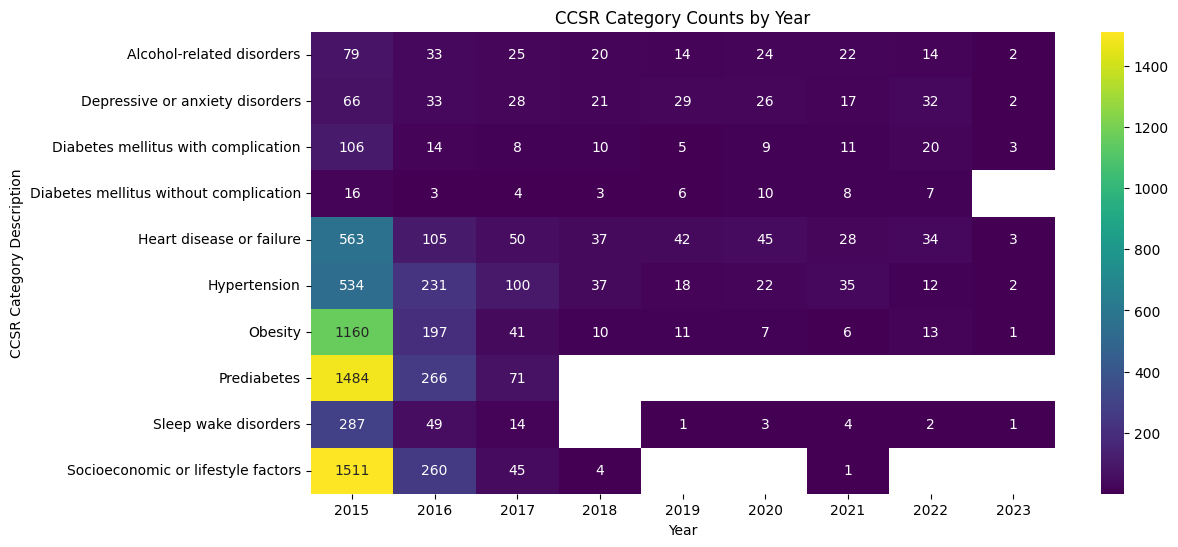

In [315]:
# prompt: Using frequency_counts, create a heatmap of CCSR_DESCRIPTION_CATEGORY by COUNT and YR.  CCSR_DESCRIPTION_CATEGORY should be on the Y axis
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table for heatmap data
heatmap_data = frequency_counts.pivot(index='CCSR_CATEGORY_DESCRIPTION_updated', columns='YR', values='Count')

# Create the heatmap
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='viridis')
plt.title('CCSR Category Counts by Year')
plt.xlabel('Year')
plt.ylabel('CCSR Category Description')
plt.show()

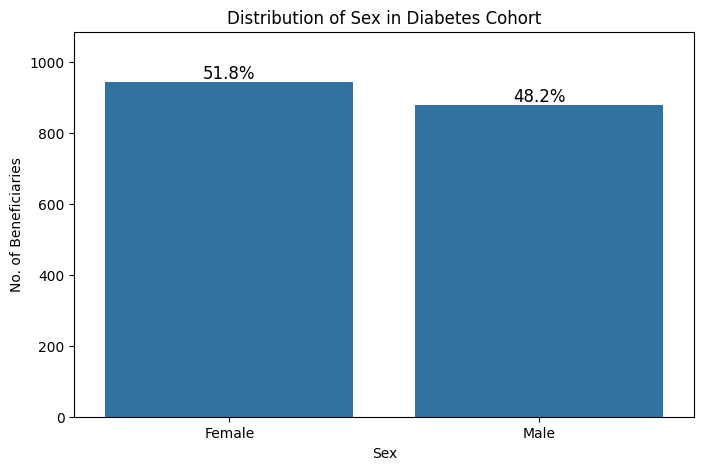

In [316]:
# prompt: make a barplot of values of SEX_IDENT_CD in enrollment_full. Labels: 0=Unknown, 1=Male, 2=Female

import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each SEX_IDENT_CD value
sex_counts = enrollment_full['SEX_IDENT_CD'].value_counts().reset_index()
sex_counts.columns = ['SEX_IDENT_CD', 'Count']

# Compute percentages
total_count = sex_counts['Count'].sum()
sex_counts['Percentage'] = (sex_counts['Count'] / total_count) * 100

# Map numerical values to labels
## See pg. 53 of membership codebook: https://www2.ccwdata.org/documents/10280/19022436/codebook-mbsf-abcd.pdf
sex_labels = {0: 'Unknown', 1: 'Male', 2: 'Female'}
sex_counts['SEX_IDENT_CD'] = sex_counts['SEX_IDENT_CD'].map(sex_labels)

# Create the barplot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='SEX_IDENT_CD', y='Count', data=sex_counts)

# Add percentage labels on top of bars
for i, row in sex_counts.iterrows():
    ax.text(i, row['Count'] + 10, f"{row['Percentage']:.1f}%", ha='center', fontsize=12)

plt.xlabel('Sex')
plt.ylabel('No. of Beneficiaries')
plt.title('Distribution of Sex in Diabetes Cohort')
plt.ylim(0, sex_counts['Count'].max() * 1.15)
plt.show()

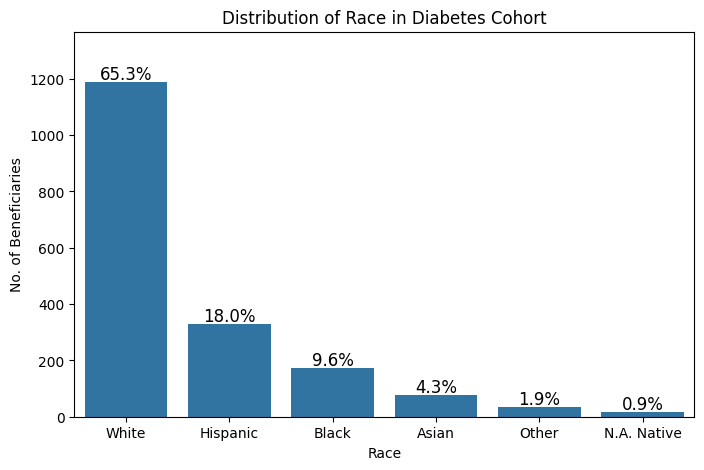

In [317]:
# Count occurrences of each BENE_RACE_CD value
race_counts = enrollment_full['BENE_RACE_CD'].value_counts().reset_index()
race_counts.columns = ['BENE_RACE_CD', 'Count']

# Compute percentages
total_count = race_counts['Count'].sum()
race_counts['Percentage'] = (race_counts['Count'] / total_count) * 100

# Map numerical values to labels
## See pg. 10 of membership codebook: https://www2.ccwdata.org/documents/10280/19022436/codebook-mbsf-abcd.pdf
race_labels = {0:'Unknown', 1:'White', 2:'Black', 3:'Other', 4:'Asian', 5:'Hispanic', 6:'N.A. Native'}
race_counts['BENE_RACE_CD'] = race_counts['BENE_RACE_CD'].map(race_labels)

# Create the barplot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='BENE_RACE_CD', y='Count', data=race_counts)

# Add percentage labels on top of bars
for i, row in race_counts.iterrows():
    ax.text(i, row['Count'] + 10, f"{row['Percentage']:.1f}%", ha='center', fontsize=12)

plt.xlabel('Race')
plt.ylabel('No. of Beneficiaries')
plt.title('Distribution of Race in Diabetes Cohort')
plt.ylim(0, race_counts['Count'].max() * 1.15)
plt.show()

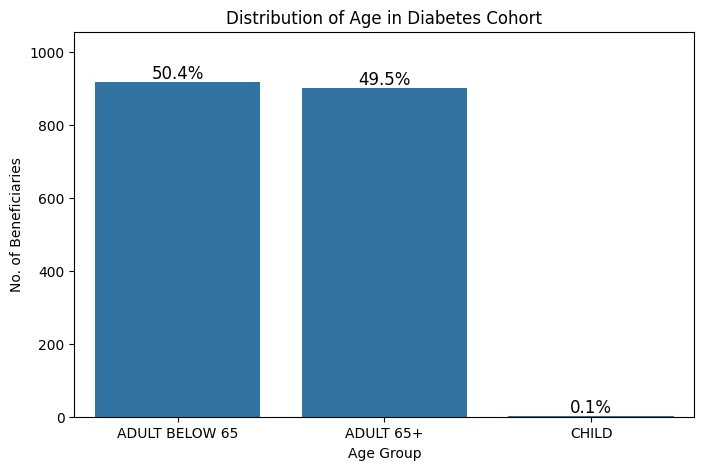

In [318]:
# Count occurrences of each AGE_GRP value
age_counts = enrollment_full['AGE_GRP'].value_counts().reset_index()
age_counts.columns = ['AGE_GRP', 'Count']

# Compute percentages
total_count = age_counts['Count'].sum()
age_counts['Percentage'] = (age_counts['Count'] / total_count) * 100

# Create the barplot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='AGE_GRP', y='Count', data=age_counts)

# Add percentage labels on top of bars
for i, row in age_counts.iterrows():
    ax.text(i, row['Count'] + 10, f"{row['Percentage']:.1f}%", ha='center', fontsize=12)

plt.xlabel('Age Group')
plt.ylabel('No. of Beneficiaries')
plt.title('Distribution of Age in Diabetes Cohort')
plt.ylim(0, age_counts['Count'].max() * 1.15)
plt.show()

In [319]:
diabetes_full.to_csv('/content/drive/MyDrive/Data/Output/diabetes_cohort.csv', index=False)
enrollment_full.to_csv('/content/drive/MyDrive/Data/Output/enrollment_cohort.csv', index=False)